## STEP 1: Import Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [41]:
# Create output directory
OUTPUT_DIR = './evaluation_results'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Output directory: ./evaluation_results


## STEP 2: Load the Saved Model

In [42]:
# Load the saved Random Forest model and scaler
MODEL_PATH = './model/random_forest_model.joblib'
SCALER_PATH = './model/scaler.joblib'

# Check if files exist
print("Checking model files...")
print(f"  Model file exists: {os.path.exists(MODEL_PATH)}")
print(f"  Scaler file exists: {os.path.exists(SCALER_PATH)}")

# Load model and scaler
RF_model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

print("\n✓ Random Forest model loaded successfully!")
print(f"✓ Model type: {type(RF_model).__name__}")
print(f"✓ Number of trees: {RF_model.n_estimators}")

Checking model files...
  Model file exists: True
  Scaler file exists: True

✓ Random Forest model loaded successfully!
✓ Model type: RandomForestClassifier
✓ Number of trees: 100


## STEP 3: Load and Prepare Test Data

In [43]:
# Load the dataset
dataset = pd.read_csv('../dataset/train_dataset.csv', index_col=0)
print(f"Dataset loaded: {dataset.shape[0]} transactions, {dataset.shape[1]} features")
dataset.head()

Dataset loaded: 16426 transactions, 7 features


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.0,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.0,21182.0,0.0,1
251,TRANSFER,2806.00,2806.0,0.0,0.0,0.0,1
252,CASH_OUT,2806.00,2806.0,0.0,26202.0,0.0,1
320,PAYMENT,14420.66,0.0,0.0,0.0,0.0,0


In [44]:
# Encode categorical column 'type'
label_encoder = LabelEncoder()
dataset['type'] = label_encoder.fit_transform(dataset['type'].astype(str))

# Show encoding
type_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Transaction Type Encoding: {type_mapping}")

Transaction Type Encoding: {'CASH_IN': np.int64(0), 'CASH_OUT': np.int64(1), 'DEBIT': np.int64(2), 'PAYMENT': np.int64(3), 'TRANSFER': np.int64(4)}


In [45]:
# Separate features and target
X = dataset.iloc[:, :6].values
y = dataset.iloc[:, 6].values

# Split data (same split as training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale the test data using the loaded scaler
X_test_scaled = scaler.transform(X_test)

print(f"Test set: {X_test.shape[0]} samples")
print(f"  - Genuine: {np.sum(y_test == 0)}")
print(f"  - Fraud: {np.sum(y_test == 1)}")

Test set: 2464 samples
  - Genuine: 1212
  - Fraud: 1252


## STEP 4: Test the Model

In [46]:
# Make predictions
y_pred = RF_model.predict(X_test_scaled)
y_prob = RF_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("="*50)
print("RANDOM FOREST MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy:    {accuracy * 100:.2f}%")
print(f"Precision:   {precision * 100:.2f}%")
print(f"Recall:      {recall * 100:.2f}%")
print(f"F1-Score:    {f1 * 100:.2f}%")
print(f"ROC-AUC:     {roc_auc:.4f}")
print("="*50)

RANDOM FOREST MODEL PERFORMANCE
Accuracy:    99.47%
Precision:   99.13%
Recall:      99.84%
F1-Score:    99.48%
ROC-AUC:     0.9992


---
# VISUALIZATIONS FOR PRESENTATION
---

## VISUALIZATION 1: Class Distribution

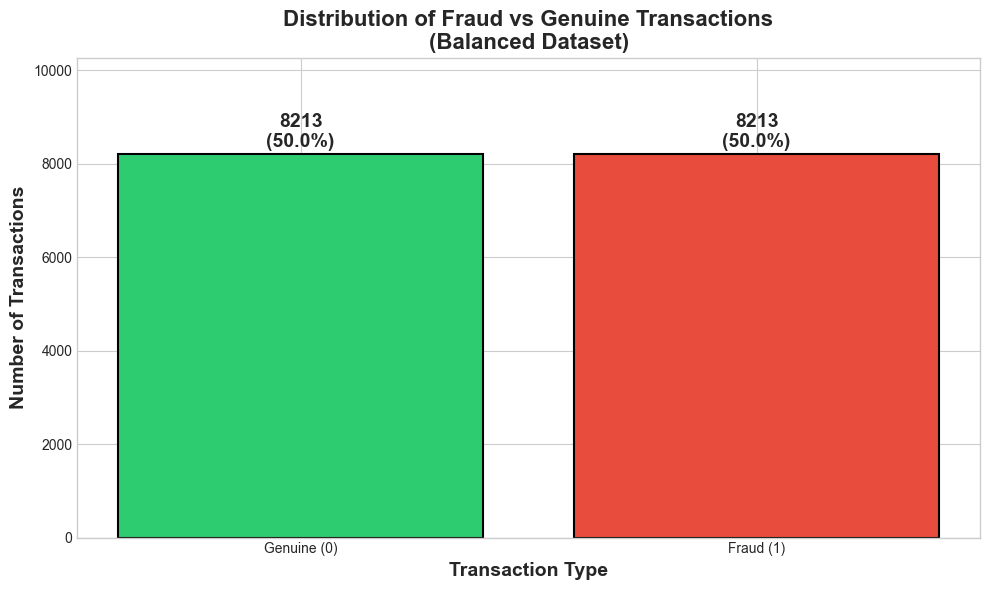

✓ Saved: class_distribution.png


In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

class_counts = pd.Series(y).value_counts().sort_index()
class_labels = ['Genuine (0)', 'Fraud (1)']
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(class_labels, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)

total = sum(class_counts.values)
for bar, count in zip(bars, class_counts.values):
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_xlabel('Transaction Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Transactions', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Fraud vs Genuine Transactions\n(Balanced Dataset)', 
             fontsize=16, fontweight='bold')
ax.set_ylim(0, max(class_counts.values) * 1.25)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: class_distribution.png")

## VISUALIZATION 2: Confusion Matrix


✓ True Positives (Frauds Caught): 1250
✓ True Negatives (Genuine Correct): 1201
✗ False Positives (False Alarms): 11
✗ False Negatives (Missed Frauds): 2

→ Fraud Detection Rate: 99.8%


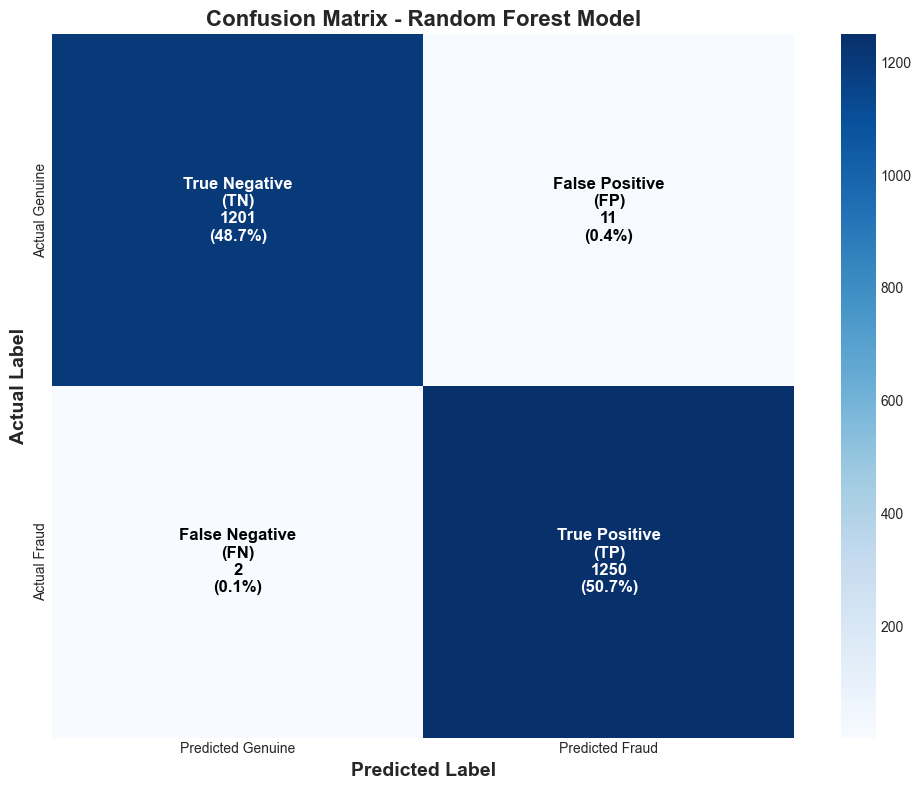


✓ Saved: confusion_matrix_rf.png


In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100

sns.heatmap(cm, annot=False, cmap='Blues', ax=ax, cbar=True,
            xticklabels=['Predicted Genuine', 'Predicted Fraud'],
            yticklabels=['Actual Genuine', 'Actual Fraud'])

labels = [['True Negative\n(TN)', 'False Positive\n(FP)'],
          ['False Negative\n(FN)', 'True Positive\n(TP)']]

for i in range(2):
    for j in range(2):
        text = f"{labels[i][j]}\n{cm[i][j]}\n({cm_percent[i][j]:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', 
                fontsize=12, fontweight='bold',
                color='white' if cm[i][j] > cm.max()/2 else 'black')

ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix - Random Forest Model', fontsize=16, fontweight='bold')

tn, fp, fn, tp = cm.ravel()
print(f"\n✓ True Positives (Frauds Caught): {tp}")
print(f"✓ True Negatives (Genuine Correct): {tn}")
print(f"✗ False Positives (False Alarms): {fp}")
print(f"✗ False Negatives (Missed Frauds): {fn}")
print(f"\n→ Fraud Detection Rate: {(tp/(tp+fn))*100:.1f}%")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved: confusion_matrix_rf.png")

## VISUALIZATION 3: ROC Curve

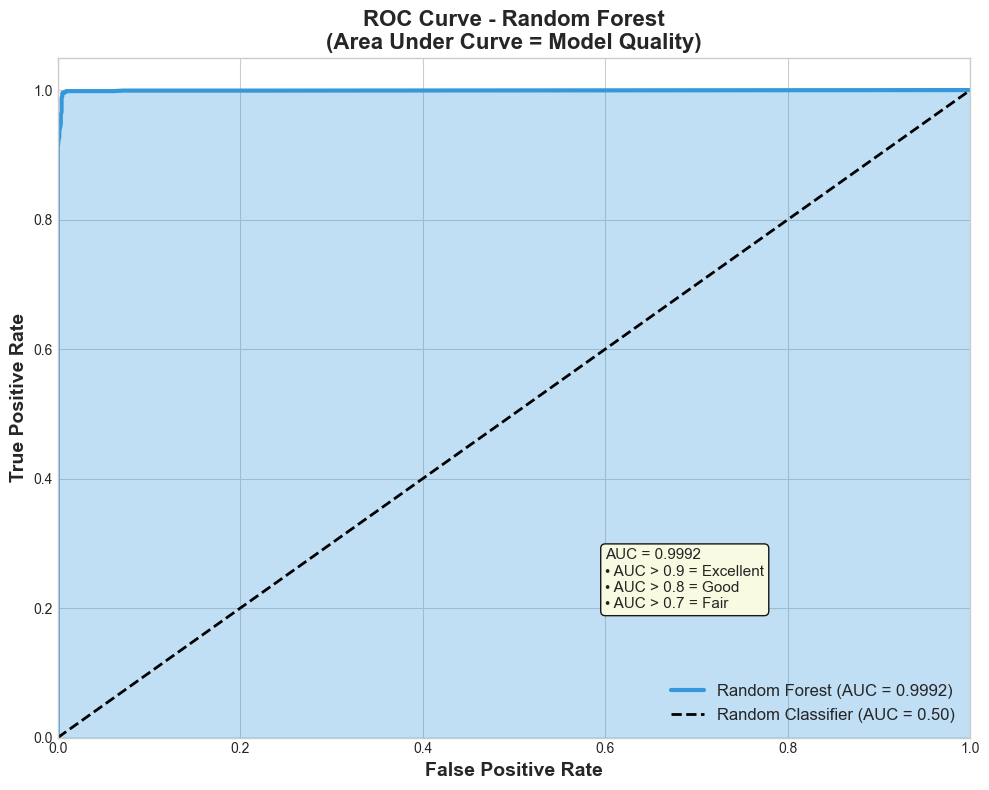

✓ Saved: roc_curve_rf.png


In [49]:
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

ax.plot(fpr, tpr, color='#3498db', linewidth=3, 
        label=f'Random Forest (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')

ax.fill_between(fpr, tpr, alpha=0.3, color='#3498db')

ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curve - Random Forest\n(Area Under Curve = Model Quality)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

# Add interpretation box
interpretation = f"AUC = {roc_auc:.4f}\n• AUC > 0.9 = Excellent\n• AUC > 0.8 = Good\n• AUC > 0.7 = Fair"
ax.text(0.6, 0.2, interpretation, fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curve_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: roc_curve_rf.png")

## VISUALIZATION 4: Precision-Recall Curve

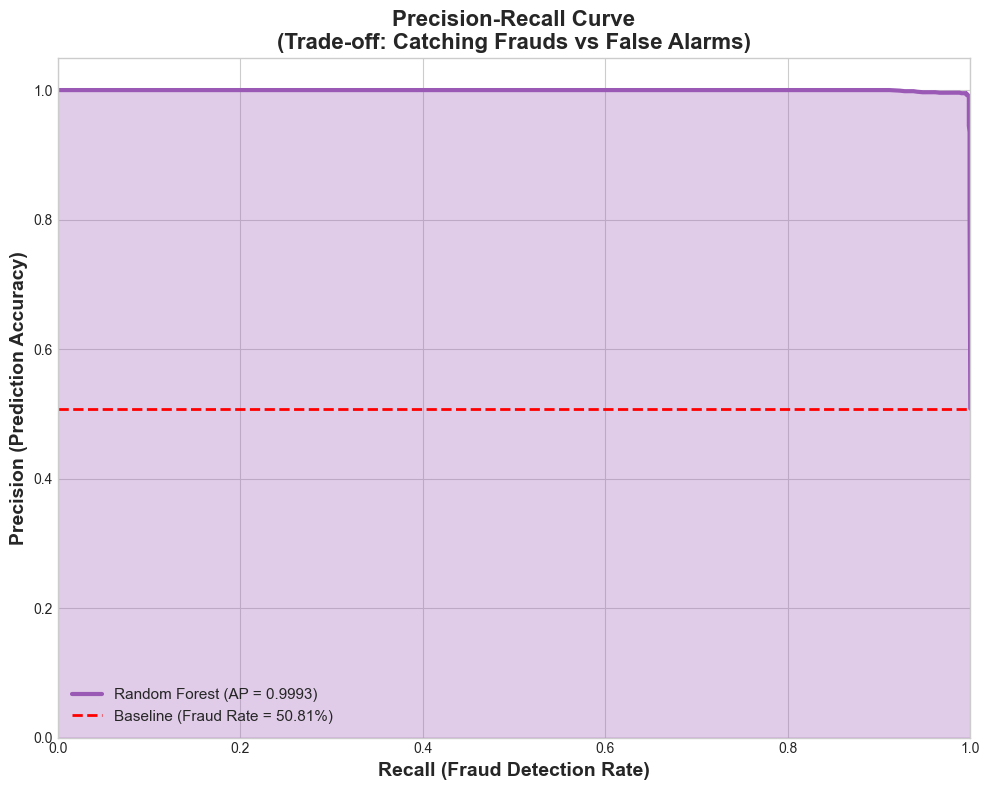

✓ Saved: precision_recall_curve_rf.png


In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

ax.plot(recall_curve, precision_curve, color='#9b59b6', linewidth=3, 
        label=f'Random Forest (AP = {avg_precision:.4f})')

fraud_rate = sum(y_test) / len(y_test)
ax.axhline(y=fraud_rate, color='red', linestyle='--', linewidth=2,
           label=f'Baseline (Fraud Rate = {fraud_rate:.2%})')

ax.fill_between(recall_curve, precision_curve, alpha=0.3, color='#9b59b6')

ax.set_xlabel('Recall (Fraud Detection Rate)', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision (Prediction Accuracy)', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Curve\n(Trade-off: Catching Frauds vs False Alarms)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower left', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/precision_recall_curve_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: precision_recall_curve_rf.png")

## VISUALIZATION 5: Feature Importance


🔑 Most Important Feature: Old Balance (Origin)
   The model relies on this feature most for detecting fraud.


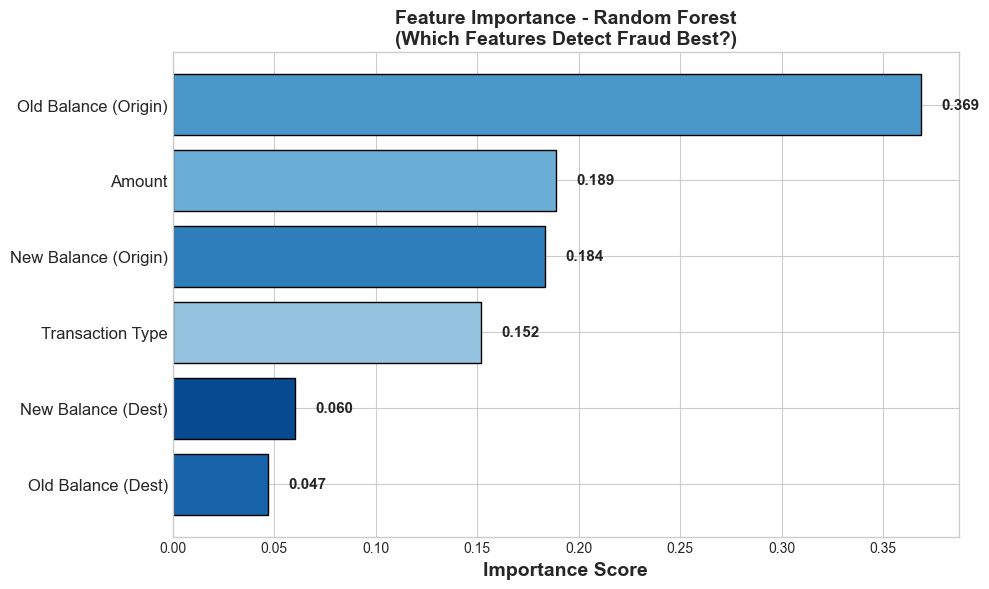


✓ Saved: feature_importance_rf.png


In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

feature_names = ['Transaction Type', 'Amount', 'Old Balance (Origin)', 
                 'New Balance (Origin)', 'Old Balance (Dest)', 'New Balance (Dest)']

importances = RF_model.feature_importances_
indices = np.argsort(importances)

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_names)))
bars = ax.barh(range(len(feature_names)), importances[indices], 
               color=colors[indices], edgecolor='black')

ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels([feature_names[i] for i in indices], fontsize=12)
ax.set_xlabel('Importance Score', fontsize=14, fontweight='bold')
ax.set_title('Feature Importance - Random Forest\n(Which Features Detect Fraud Best?)', 
             fontsize=14, fontweight='bold')

for bar, imp in zip(bars, importances[indices]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{imp:.3f}', va='center', fontsize=11, fontweight='bold')

# Highlight most important
top_feature = feature_names[indices[-1]]
print(f"\n🔑 Most Important Feature: {top_feature}")
print(f"   The model relies on this feature most for detecting fraud.")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved: feature_importance_rf.png")

## VISUALIZATION 6: Prediction Confidence Distribution

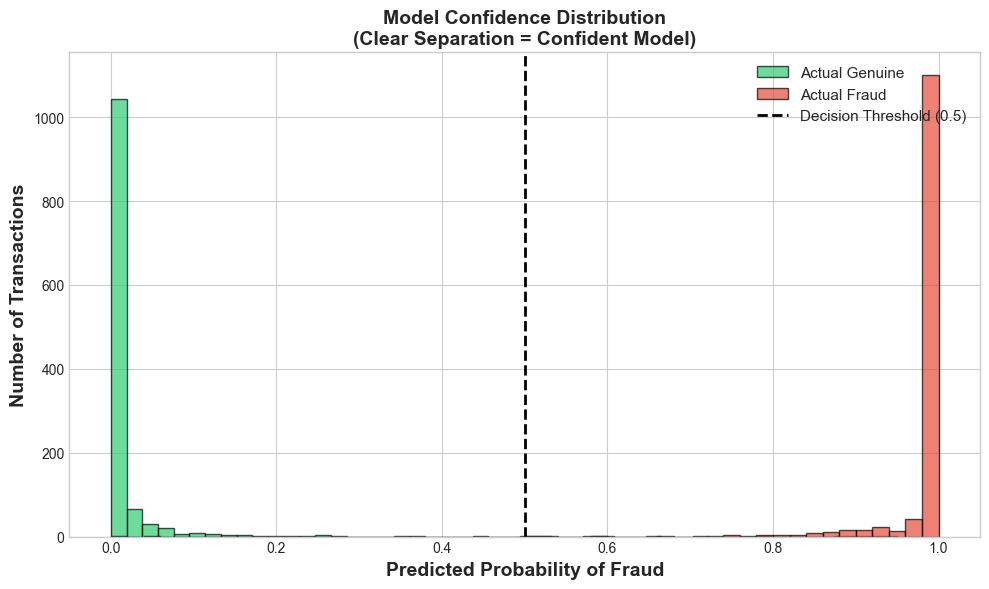

✓ Saved: prediction_distribution_rf.png


In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

genuine_probs = y_prob[y_test == 0]
fraud_probs = y_prob[y_test == 1]

ax.hist(genuine_probs, bins=50, alpha=0.7, color='#2ecc71', 
        label='Actual Genuine', edgecolor='black')
ax.hist(fraud_probs, bins=50, alpha=0.7, color='#e74c3c', 
        label='Actual Fraud', edgecolor='black')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)')

ax.set_xlabel('Predicted Probability of Fraud', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Transactions', fontsize=14, fontweight='bold')
ax.set_title('Model Confidence Distribution\n(Clear Separation = Confident Model)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/prediction_distribution_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: prediction_distribution_rf.png")

## VISUALIZATION 7: Classification Report

In [53]:
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Genuine', 'Fraud']))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Genuine       1.00      0.99      0.99      1212
       Fraud       0.99      1.00      0.99      1252

    accuracy                           0.99      2464
   macro avg       0.99      0.99      0.99      2464
weighted avg       0.99      0.99      0.99      2464



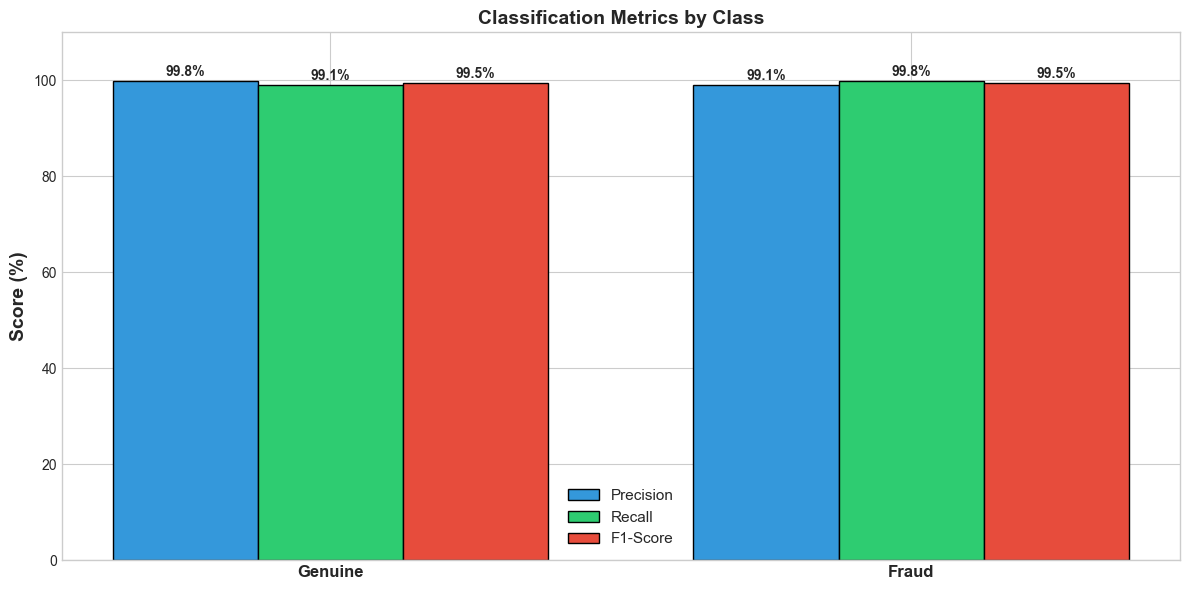

✓ Saved: classification_report_rf.png


In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

report = classification_report(y_test, y_pred, target_names=['Genuine', 'Fraud'], output_dict=True)
report_df = pd.DataFrame(report).T.drop(['accuracy', 'macro avg', 'weighted avg'])
report_df = report_df[['precision', 'recall', 'f1-score']]

x = np.arange(len(report_df.index))
width = 0.25

bars1 = ax.bar(x - width, report_df['precision'] * 100, width, 
               label='Precision', color='#3498db', edgecolor='black')
bars2 = ax.bar(x, report_df['recall'] * 100, width, 
               label='Recall', color='#2ecc71', edgecolor='black')
bars3 = ax.bar(x + width, report_df['f1-score'] * 100, width, 
               label='F1-Score', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(report_df.index, fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(0, 110)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{bar.get_height():.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/classification_report_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: classification_report_rf.png")

## VISUALIZATION 8: Model Performance Summary

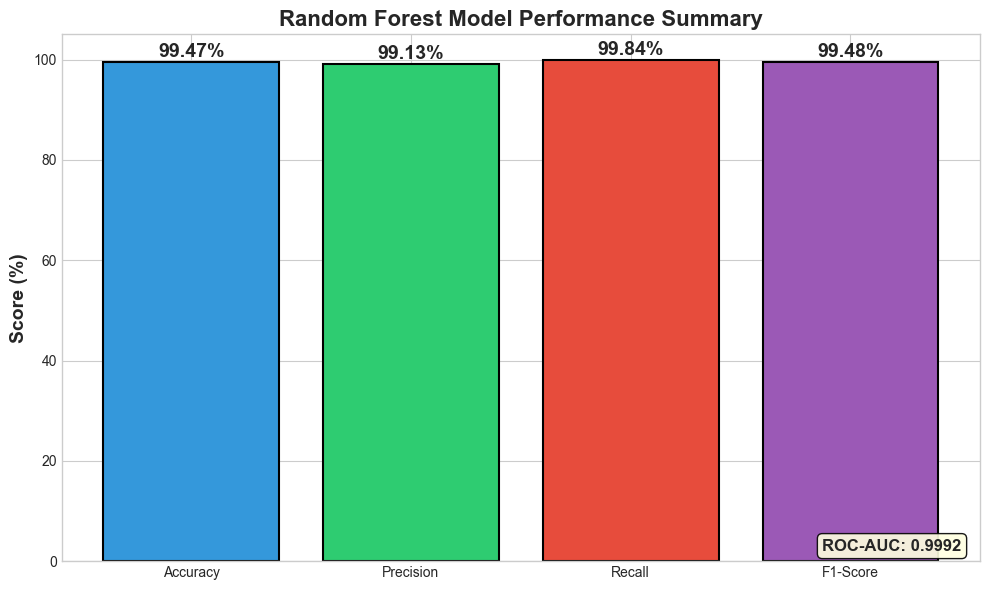

✓ Saved: model_performance_summary.png


In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.2f}%', ha='center', fontsize=14, fontweight='bold')

ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Random Forest Model Performance Summary', fontsize=16, fontweight='bold')
ax.set_ylim(0, 105)

# Add ROC-AUC annotation
ax.text(0.98, 0.02, f'ROC-AUC: {roc_auc:.4f}', transform=ax.transAxes, 
        ha='right', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/model_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: model_performance_summary.png")

---
## DEMO: Test on Sample Transactions

In [56]:
print("\n" + "="*60)
print("DEMO: PREDICT ON SAMPLE TRANSACTIONS")
print("="*60)

# Sample transactions
# Features: [type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest]
sample_transactions = np.array([
    [4, 50000, 50000, 0, 0, 50000],      # TRANSFER: Balance emptied
    [3, 100, 50000, 49900, 0, 100],       # PAYMENT: Normal small payment
    [1, 100000, 100000, 0, 0, 100000],    # CASH_OUT: Full withdrawal
    [0, 500, 1000, 1500, 0, 0],           # CASH_IN: Normal deposit
])

transaction_types = ['TRANSFER (Balance Emptied)', 'PAYMENT (Normal)', 
                     'CASH_OUT (Full Withdrawal)', 'CASH_IN (Deposit)']

# Scale and predict
sample_scaled = scaler.transform(sample_transactions)
predictions = RF_model.predict(sample_scaled)
probabilities = RF_model.predict_proba(sample_scaled)[:, 1]

print("\nTransaction Predictions:")
print("-" * 60)
for i, (trans_type, pred, prob) in enumerate(zip(transaction_types, predictions, probabilities)):
    status = "🚨 FRAUD" if pred == 1 else "✅ GENUINE"
    print(f"{i+1}. {trans_type}")
    print(f"   → {status} (Fraud Probability: {prob:.2%})")
    print()


DEMO: PREDICT ON SAMPLE TRANSACTIONS

Transaction Predictions:
------------------------------------------------------------
1. TRANSFER (Balance Emptied)
   → 🚨 FRAUD (Fraud Probability: 56.00%)

2. PAYMENT (Normal)
   → ✅ GENUINE (Fraud Probability: 0.00%)

3. CASH_OUT (Full Withdrawal)
   → 🚨 FRAUD (Fraud Probability: 98.00%)

4. CASH_IN (Deposit)
   → ✅ GENUINE (Fraud Probability: 9.00%)



---
## Generate Summary Report

In [57]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

summary_text = f"""
================================================================================
           UPI FRAUD DETECTION - MODEL TEST RESULTS
================================================================================

MODEL: Random Forest Classifier
--------------------------------
• Number of Trees: {RF_model.n_estimators}
• Model File: {MODEL_PATH}

TEST DATA:
----------
• Total Test Samples: {len(y_test)}
• Genuine Transactions: {np.sum(y_test == 0)}
• Fraud Transactions: {np.sum(y_test == 1)}

PERFORMANCE METRICS:
--------------------
• Accuracy:    {accuracy * 100:.2f}%
• Precision:   {precision * 100:.2f}%
• Recall:      {recall * 100:.2f}%
• F1-Score:    {f1 * 100:.2f}%
• ROC-AUC:     {roc_auc:.4f}

CONFUSION MATRIX:
-----------------
• True Positives (TP):  {tp} - Frauds correctly detected
• True Negatives (TN):  {tn} - Genuine correctly identified
• False Positives (FP): {fp} - False alarms
• False Negatives (FN): {fn} - Missed frauds

• Fraud Detection Rate: {(tp/(tp+fn))*100:.1f}%
• False Alarm Rate:     {(fp/(fp+tn))*100:.1f}%

FEATURE IMPORTANCE:
-------------------
"""

for idx in np.argsort(RF_model.feature_importances_)[::-1]:
    summary_text += f"  • {feature_names[idx]}: {RF_model.feature_importances_[idx]:.4f}\n"

summary_text += """
VISUALIZATIONS GENERATED:
-------------------------
1. class_distribution.png
2. confusion_matrix_rf.png
3. roc_curve_rf.png
4. precision_recall_curve_rf.png
5. feature_importance_rf.png
6. prediction_distribution_rf.png
7. classification_report_rf.png
8. model_performance_summary.png

================================================================================
"""

with open(f'{OUTPUT_DIR}/evaluation_summary.txt', 'w') as f:
    f.write(summary_text)

print(summary_text)
print(f"✓ Summary saved to: {OUTPUT_DIR}/evaluation_summary.txt")


           UPI FRAUD DETECTION - MODEL TEST RESULTS

MODEL: Random Forest Classifier
--------------------------------
• Number of Trees: 100
• Model File: ./model/random_forest_model.joblib

TEST DATA:
----------
• Total Test Samples: 2464
• Genuine Transactions: 1212
• Fraud Transactions: 1252

PERFORMANCE METRICS:
--------------------
• Accuracy:    99.47%
• Precision:   99.13%
• Recall:      99.84%
• F1-Score:    99.48%
• ROC-AUC:     0.9992

CONFUSION MATRIX:
-----------------
• True Positives (TP):  1250 - Frauds correctly detected
• True Negatives (TN):  1201 - Genuine correctly identified
• False Positives (FP): 11 - False alarms
• False Negatives (FN): 2 - Missed frauds

• Fraud Detection Rate: 99.8%
• False Alarm Rate:     0.9%

FEATURE IMPORTANCE:
-------------------
  • Old Balance (Origin): 0.3689
  • Amount: 0.1887
  • New Balance (Origin): 0.1837
  • Transaction Type: 0.1518
  • New Balance (Dest): 0.0601
  • Old Balance (Dest): 0.0468

VISUALIZATIONS GENERATED:
--------

---
## Final Summary

In [58]:
print("\n" + "="*60)
print("           MODEL TESTING COMPLETE! ✓")
print("="*60)
print(f"\n✓ Model loaded from: {MODEL_PATH}")
print(f"✓ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✓ Fraud Detection Rate: {(tp/(tp+fn))*100:.1f}%")
print(f"\n✓ All visualizations saved to: {OUTPUT_DIR}/")
print("\nFiles generated:")
for filename in sorted(os.listdir(OUTPUT_DIR)):
    filepath = os.path.join(OUTPUT_DIR, filename)
    size = os.path.getsize(filepath) / 1024
    print(f"  • {filename} ({size:.1f} KB)")

print("\n" + "="*60)
print("Ready for your B.Tech presentation! 🎓")
print("="*60)


           MODEL TESTING COMPLETE! ✓

✓ Model loaded from: ./model/random_forest_model.joblib
✓ Test Accuracy: 99.47%
✓ Fraud Detection Rate: 99.8%

✓ All visualizations saved to: ./evaluation_results/

Files generated:
  • class_distribution.png (135.8 KB)
  • classification_report_rf.png (109.1 KB)
  • confusion_matrix_rf.png (185.3 KB)
  • evaluation_summary.txt (1.5 KB)
  • feature_importance_rf.png (166.7 KB)
  • model_comparison_summary.png (292.7 KB)
  • model_metrics.csv (0.3 KB)
  • model_performance_summary.png (121.9 KB)
  • precision_recall_curve_rf.png (170.6 KB)
  • prediction_distribution_rf.png (149.9 KB)
  • roc_curve_rf.png (247.3 KB)
  • roc_curves_comparison.png (350.7 KB)

Ready for your B.Tech presentation! 🎓
